In [1]:
DIMENSION = 15  #Hiperparametro de dimensiones para las pruebas

In [2]:
import numpy as np
import random as rnd
import math
from scipy.spatial import distance
np.random.seed(0)
rnd.seed(0)

class Problem:
    def __init__(self):
        self.dimension = DIMENSION
        self.costs = [
                    [0, 5, 10, 15, 7, 12, 20, 8, 14, 10, 9, 11, 13, 14, 15],
                    [5, 0, 6, 9, 5, 8, 14, 4, 7, 5, 6, 12, 10, 11, 12],
                    [10, 6, 0, 8, 4, 6, 13, 7, 5, 8, 9, 13, 14, 12, 10],
                    [15, 9, 8, 0, 7, 4, 10, 5, 3, 6, 12, 9, 10, 13, 14],
                    [7, 5, 4, 7, 0, 3, 9, 6, 4, 5, 8, 10, 11, 9, 8],
                    [12, 8, 6, 4, 3, 0, 7, 3, 5, 6, 9, 14, 13, 12, 11],
                    [20, 14, 13, 10, 9, 7, 0, 6, 5, 8, 10, 15, 14, 12, 13],
                    [8, 4, 7, 5, 6, 3, 6, 0, 2, 5, 7, 9, 8, 10, 11],
                    [14, 7, 5, 3, 4, 5, 5, 2, 0, 3, 8, 10, 11, 9, 8],
                    [10, 5, 8, 6, 5, 6, 8, 5, 3, 0, 4, 11, 10, 9, 12],
                    [9, 6, 9, 12, 8, 9, 10, 7, 8, 4, 0, 12, 13, 14, 15],
                    [11, 12, 13, 9, 10, 14, 15, 9, 10, 11, 12, 0, 5, 6, 7],
                    [13, 10, 14, 10, 11, 13, 14, 8, 11, 10, 13, 5, 0, 8, 9],
                    [14, 11, 12, 13, 9, 12, 12, 10, 9, 9, 14, 6, 8, 0, 4],
                    [15, 12, 10, 14, 8, 11, 13, 11, 8, 12, 15, 7, 9, 4, 0]
        ]

    def checkConstraint(self, solution):

        visitedPlaces = [0 for _ in range(self.dimension)] # Definimos un arreglo para indicar que lugares (indices) ya han sido visitados (1) o no (0)

        for fromPlace, toPlace in enumerate(solution): # Recorremos el trayecto (solution) para ver si cumple con las restricciones: fromPlace (indice), toPlace (valor)

            if visitedPlaces[toPlace] == 1: return False # Si un lugar (toPlace) ya a sido visitado previamente, entonces no es factible

            visitedPlaces[toPlace] = 1 # Marcamos el lugar (toPlace) como visitado

        # Verificamos si hay cilos contando la cantidad de recorridos que se hicieron desde el origen hasta el mismo
        previousLocation = np.where(solution == 0)[0]
        count = 0
        while previousLocation != 0:
            previousLocation = np.where(solution == previousLocation)[0]
            count+=1
        if count != len(solution)-1: # Si la cantidad de recorridoes desde el origen al origen no es igual a la cantidad de dimensiones - 1, entonces hubieron ciclos
            return False

        return True

    def fit(self, solution):

        fitness = 0

        for fromPlace, toPlace in enumerate(solution):

            fitness += self.costs[fromPlace][toPlace]

        return fitness

class RedFox:
    def __init__(self):
        self.p = Problem()

        self.tour = self.generateTour()

        self.observationAngle = self.generateObservationAngle() #Definimos un rango de visión del zorro (phi)

        self.distanceFromPrey = self.generateDistanceFromPrey() #Definimos la distancia entre el zorro y la presa (a)

        self.pbest = []

        self.updatepbest()

    def generateTour(self):
        # return np.random.randint(0, self.p.dimension, size=self.p.dimension)
        return np.random.choice(np.arange(0, self.p.dimension), size=self.p.dimension, replace=False)

    def generateObservationAngle(self):
        return np.random.uniform(0, 0.2 * math.pi, size=self.p.dimension)

    def generateDistanceFromPrey(self):
        return np.random.uniform(0, 0.2)

    def isfeasible(self):
        return self.p.checkConstraint(self.tour)

    def isbetterthan(self, o):
        return self.fitness() < o.fitness()

    def isbetterthanpbest(self):
        return self.fitness() < self.fitnesspbest()

    def fitness(self):
        return self.p.fit(self.tour)

    def fitnesspbest(self):
        return self.p.fit(self.pbest)

    def updatepbest(self):
        self.pbest = self.tour.copy()

    def copy(self, a):
        self.tour = a.tour.copy()
        self.pbest = a.pbest.copy()

    def __str__(self) -> str:
        return f"fit:{self.fitness()} x:{self.tour}"

    def move(self, g, weatherCondition, swarm, k):
        # Fase de reproducción
        sorted_population = sorted(swarm, key=lambda fox: self.p.fit(fox.tour))
        FromIndex = len(swarm)-0.05*len(swarm)
        newFoxLocation = np.zeros(self.p.dimension, dtype=float)
        if self in swarm[int(FromIndex):]:
            if k < 0.45:
                for j in range(self.p.dimension):
                    newFoxLocation[j] = k * ((sorted_population[0].tour[j] + sorted_population[1].tour[j])/2)
                self.tour = self.discretize(newFoxLocation)
            else:
                self.tour = self.generateTour()

        newPosition = np.zeros(self.p.dimension, dtype=float)

        # Fase de búsqueda global
        bestFox = g
        distanceBestFox = distance.euclidean(self.tour, bestFox.tour)

        alpha = np.random.uniform(0, distanceBestFox)

        # The fox moves toward the best fox
        for j in range(self.p.dimension):
            sign = np.sign(bestFox.tour[j] - self.tour[j])
            newPosition[j] = self.tour[j] + (alpha * sign)

        newPosition = self.discretize(newPosition)

        # If the reallocation is better than previous position, move. Otherwise return.
        if self.p.fit(newPosition) < self.fitness():
            self.tour = newPosition
        else:
            self.tour = self.pbest

        # Fase de búsqueda local

        u = np.random.uniform(0, 1)

        # If undetected, move closer. Otherwise stay
        if (u > 0.75):

            #Calculate fox observation radious r
            if (self.observationAngle[0] != 0):
                r = self.distanceFromPrey * math.sin(self.observationAngle[0] / self.observationAngle[0])
            else:
                r = weatherCondition

            #Calculate reallocation
            for j in range(self.p.dimension):

                sum_term = sum( np.sin(self.observationAngle[k+1]) for k in range(j))

                if j == self.p.dimension-1:

                    newPosition[j] = self.distanceFromPrey * r * sum_term + self.tour[j]

                else:
                    newPosition[j] = self.distanceFromPrey * r * ( sum_term + np.cos(self.observationAngle[j+1])) + self.tour[j]

            newPosition = self.discretize(newPosition)
            self.tour = newPosition

    def discretize(self, arr):
        sorted_indices = np.argsort(arr)
        discrete_arr = np.zeros_like(sorted_indices)
        discrete_arr[sorted_indices] = np.arange(len(arr)) # Assign discrete values based on the sorted order
        return discrete_arr


class RFO:
    def __init__(self):
        self.p = Problem()
        self.maxIter = 100
        self.nRedFoxes = 10
        self.swarm = []
        self.g = RedFox()
        self.weatherCondition = self.generateWeatherCondition()
        self.allFits = []

    def generateWeatherCondition(self):
        return np.random.uniform(0, 1)

    def getFitG(self):
        return self.g.fitness(), self.allFits

    def solve(self):
        self.initrand()
        self.evolve()

    def initrand(self):
        for i in range(self.nRedFoxes): # Generamos los zorros
            while True:
                p = RedFox()
                if p.isfeasible():
                    break
            self.swarm.append(p)

        self.g.copy(self.swarm[0])
        for i in range(1, self.nRedFoxes):
            if self.swarm[i].isbetterthan(self.g):
                self.g.copy(self.swarm[i])

    def evolve(self):
        t = 1
        while t <= self.maxIter:
            for i in range(self.nRedFoxes):
                k = np.random.uniform(0,1)
                while True:
                    self.swarm[i].move(self.g, self.weatherCondition, self.swarm, k)
                    if self.swarm[i].isfeasible():
                        break

                if self.swarm[i].isbetterthanpbest():
                    self.swarm[i].updatepbest()

                if self.swarm[i].isbetterthan(self.g):
                    self.g.copy(self.swarm[i])
            t = t + 1
            self.allFits.append(self.g.fitness())
r = RFO()
r.solve()
print(r.g)

fit:108 x:[ 1  5  4 10  6  8  3 11  7  0  9 12 14  2 13]


# Pruebas

In [4]:
import pandas as pd
def ejecutarRFO(ejecuciones=100):
  fits = []
  history = []
  for i in range(0, ejecuciones):
    r = RFO()
    r.solve()
    best_fit, all_fits = r.getFitG()
    fits.append(best_fit)
    history.append(all_fits)

  return fits, history

In [5]:
fit_results = []
history_all_dim = []

In [6]:
for i in range(1, 16):
  DIMENSION = i
  result, his = ejecutarRFO()
  fit_results.append(result)
  history_all_dim.append(his)

In [7]:
np_fit_results = np.array(fit_results)
np_fit_results.shape

(15, 100)

In [8]:
np_history_all_dim = np.array(history_all_dim)
np_history_all_dim.shape

(15, 100, 100)

In [9]:
np.save("fit_results.npy", np_fit_results)
np.save("history_all_dim.npy", np_history_all_dim)

In [10]:
np_fit_results = np.load("fit_results.npy")
np_history_all_dim = np.load("history_all_dim.npy")

In [11]:
np_fit_results_transposed = np_fit_results.T
df = pd.DataFrame(np_fit_results_transposed, columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,10,21,32,33,35,46,49,52,54,68,77,84,99,113
1,0,10,21,32,35,33,48,50,52,59,61,82,86,98,111
2,0,10,21,32,33,35,49,53,51,56,73,78,93,95,97
3,0,10,21,32,33,33,49,54,46,58,58,83,83,111,106
4,0,10,21,32,33,35,46,52,54,55,64,90,90,100,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,10,21,32,33,39,48,47,51,55,64,79,91,98,109
96,0,10,21,32,33,38,46,45,53,57,67,78,88,103,116
97,0,10,21,32,33,33,50,54,44,52,65,84,86,93,111
98,0,10,21,32,33,33,46,45,51,59,68,79,79,108,101


In [12]:
mins = []
maxs = []
means = []
medians = []
stds = []
IQRs = []

for i in np_fit_results:
  mins.append(np.min(i))
  maxs.append(np.max(i))
  means.append(np.mean(i))
  medians.append(np.median(i))
  stds.append(np.std(i))

  df = pd.DataFrame(i)
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = float(Q3 - Q1)
  IQRs.append(IQR)


<ipython-input-12-344e6f0458d4>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IQR = float(Q3 - Q1)
<ipython-input-12-344e6f0458d4>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IQR = float(Q3 - Q1)
<ipython-input-12-344e6f0458d4>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IQR = float(Q3 - Q1)
<ipython-input-12-344e6f0458d4>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IQR = float(Q3 - Q1)
<ipython-input-12-344e6f0458d4>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IQR = float

In [13]:
table = pd.DataFrame({'Min': mins, 'Max': maxs, 'Mean': means, 'Median': medians, 'Std': stds,
                              'IQR': IQRs}, index=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15))
table

,Min,Max,Mean,Median,Std,IQR
1,0,0,0.00,0.0,0.000000,0.00
2,10,10,10.00,10.0,0.000000,0.00
3,21,21,21.00,21.0,0.000000,0.00
4,32,32,32.00,32.0,0.000000,0.00
5,33,35,33.22,33.0,0.625780,0.00
6,33,39,34.53,35.0,1.539188,2.00
7,46,55,47.94,48.0,2.067946,3.00
8,45,56,49.47,49.5,3.115943,5.25
9,44,66,50.65,50.5,3.667083,4.00
10,50,62,55.86,56.0,2.946252,4.25


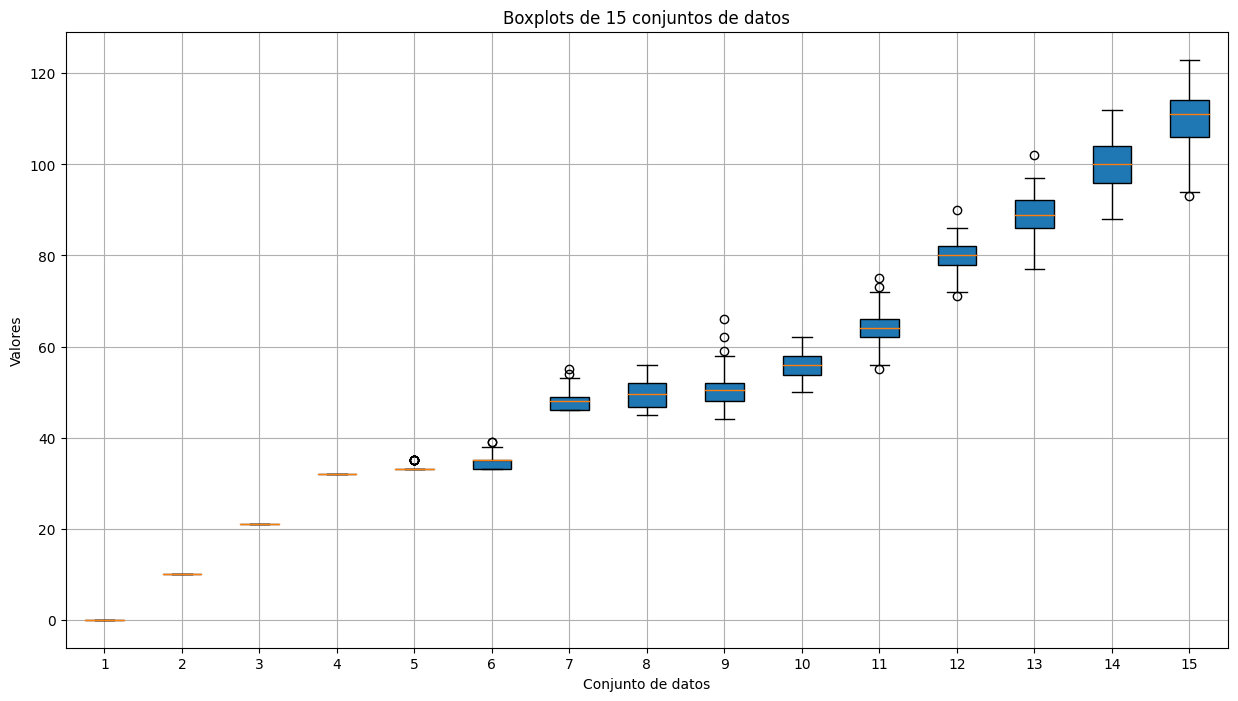

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generar un array de tamaño (15, 100) con datos aleatorios
data = np_fit_results

# Crear un gráfico de boxplots
plt.figure(figsize=(15, 8))
plt.boxplot(data.T, patch_artist=True)
plt.title('Boxplots de 15 conjuntos de datos')
plt.xlabel('Conjunto de datos')
plt.ylabel('Valores')
plt.grid(True)
plt.show()

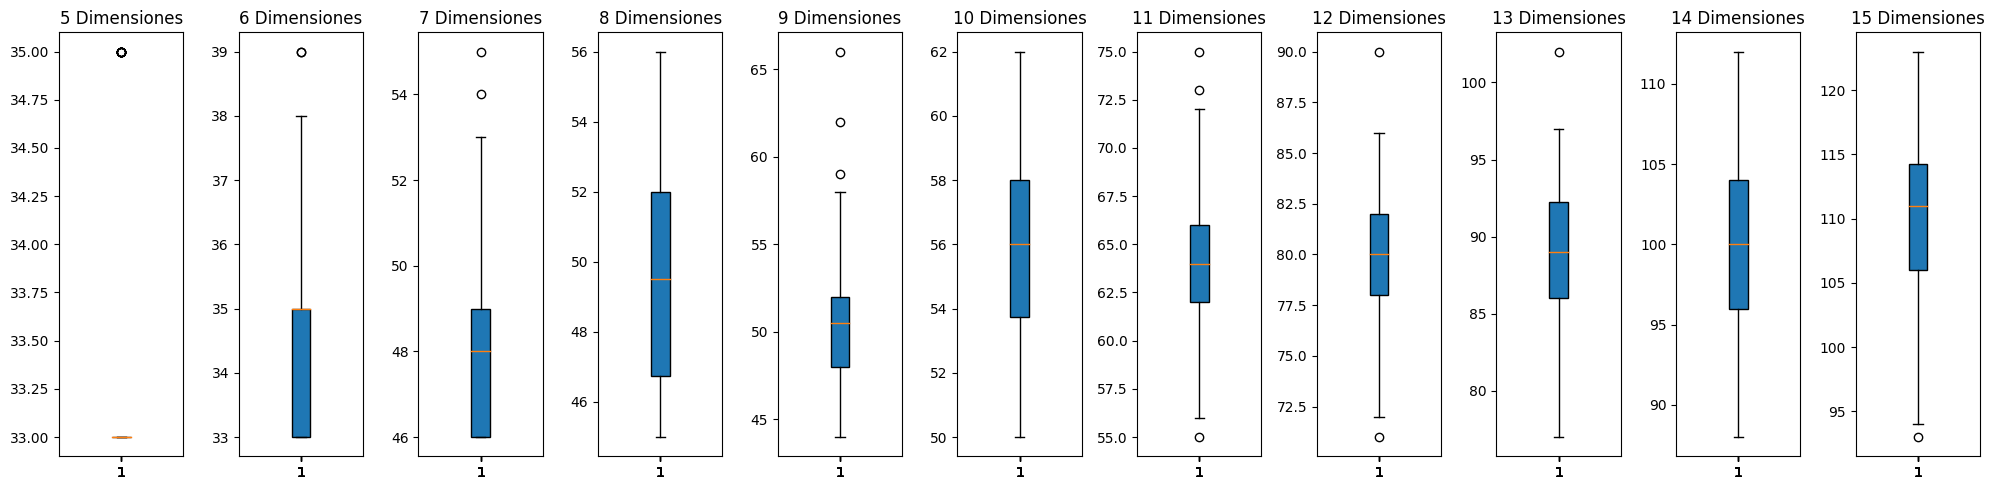

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Generar un array de tamaño (15, 100) con datos aleatorios
data = np_fit_results[4:]

# Crear una figura con 15 subplots, uno por cada fila de datos
fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(20, 5), sharex=True)

# Generar los boxplots en cada subplot
for i, ax in enumerate(axes):
    ax.boxplot(data[i], patch_artist=True)
    ax.set_title(f'{i+5} Dimensiones')
    ax.yaxis.set_tick_params(labelleft=True)

plt.tight_layout()
plt.show()

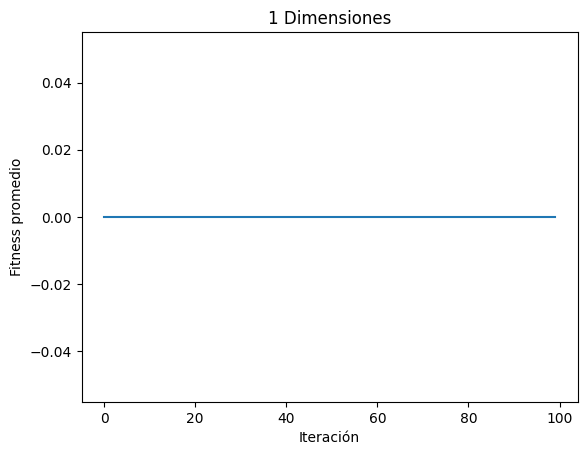

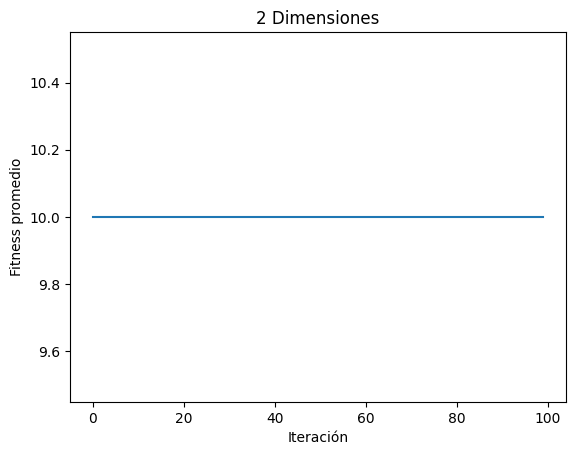

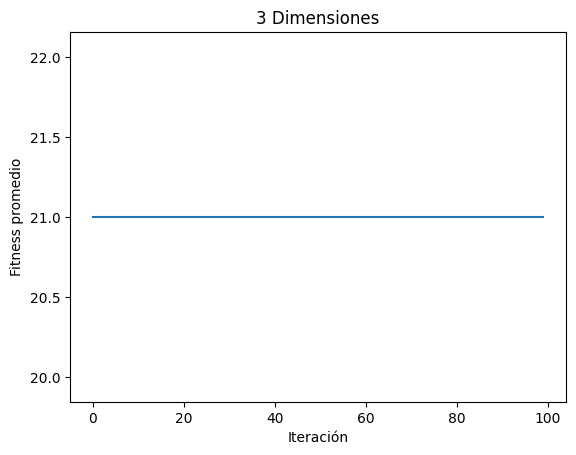

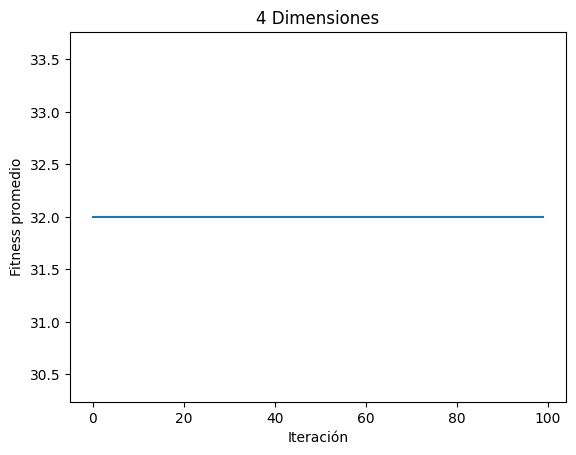

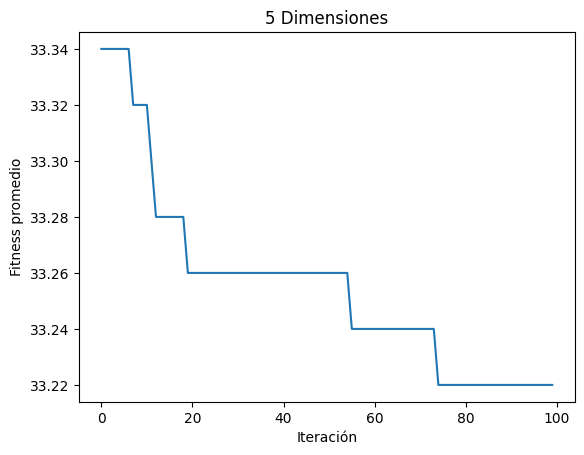

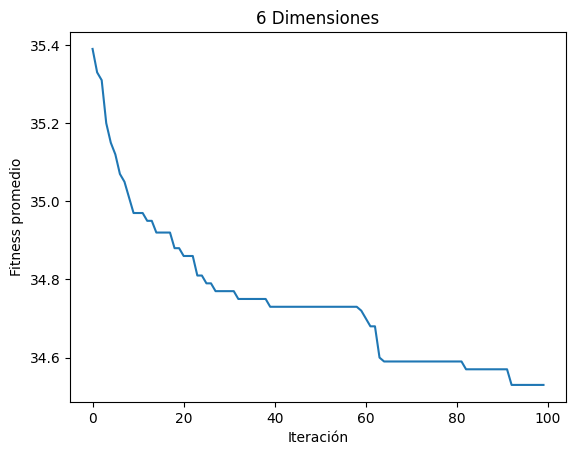

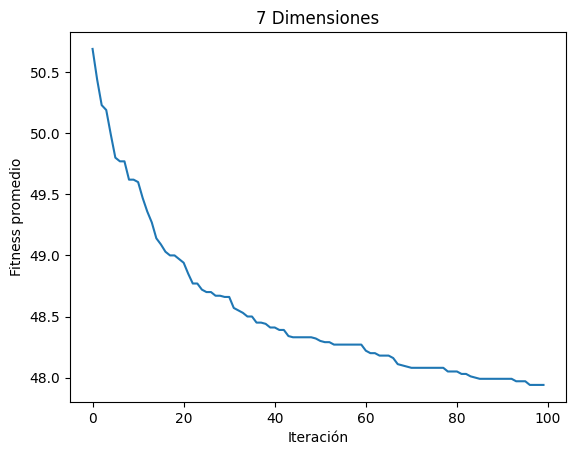

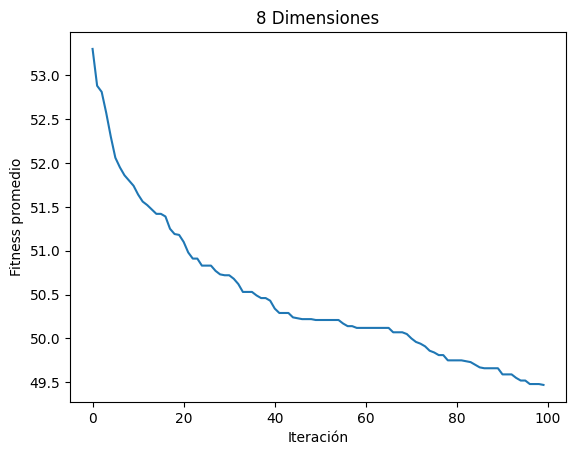

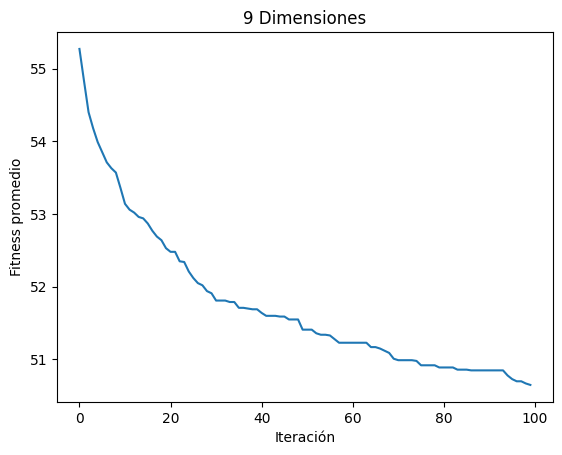

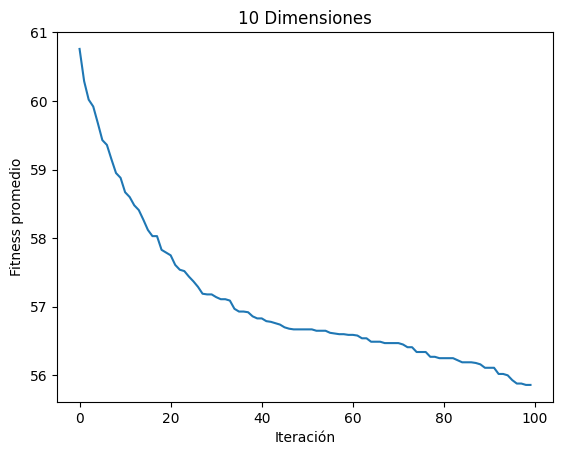

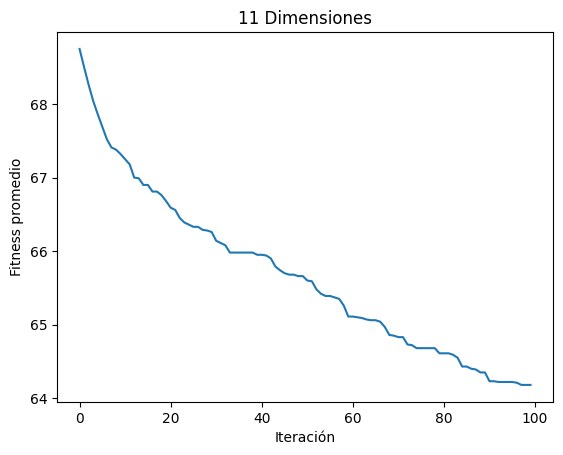

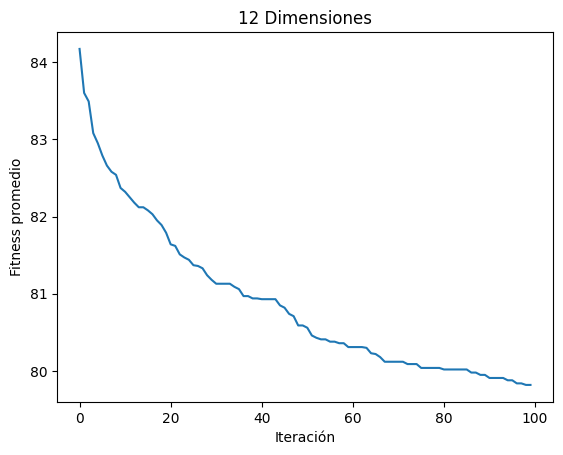

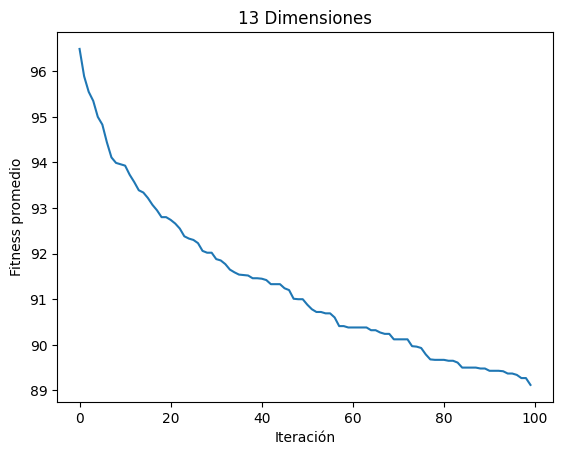

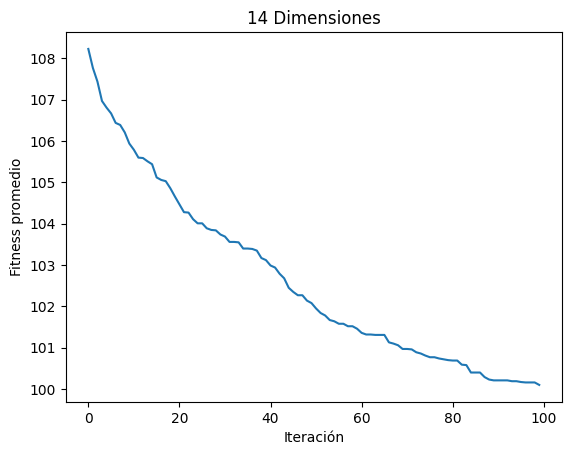

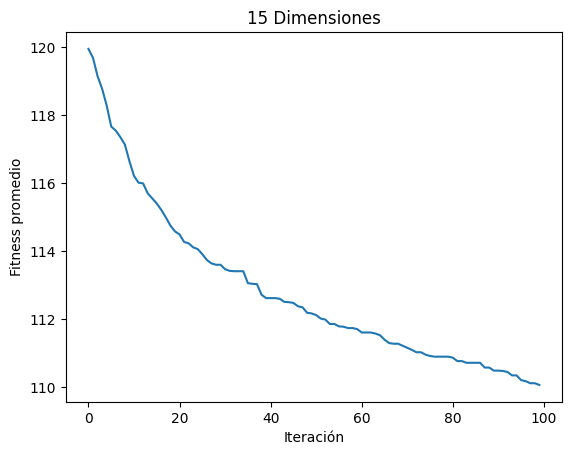

In [14]:
import matplotlib.pyplot as plt
for i in range(0, 15):
  np_history_all_dim_transposed = np_history_all_dim[i].T
  iteration_means = []
  for j in np_history_all_dim_transposed:
    iteration_means.append(np.mean(j))
  plt.plot(iteration_means)
  plt.title(f"{i+1} Dimensiones")
  plt.xlabel("Iteración")
  plt.ylabel("Fitness promedio")
  plt.show()

In [ ]:
np_history_all_dim.shape

(15, 100, 100)

In [ ]:
np_history_all_dim = np.array(history_all_dim)
np_history_all_dim.shape

(2, 100, 100)

In [ ]:
np_history_all_dim[0]

array([[48, 48, 48, ..., 48, 48, 48],
       [54, 54, 48, ..., 48, 48, 48],
       [51, 51, 51, ..., 51, 51, 51],
       ...,
       [56, 56, 56, ..., 51, 51, 51],
       [50, 50, 50, ..., 50, 50, 50],
       [54, 54, 54, ..., 46, 46, 46]])

In [ ]:
t = np_history_all_dim[1].T
means = []
for i in t:
  means.append(np.mean(i))

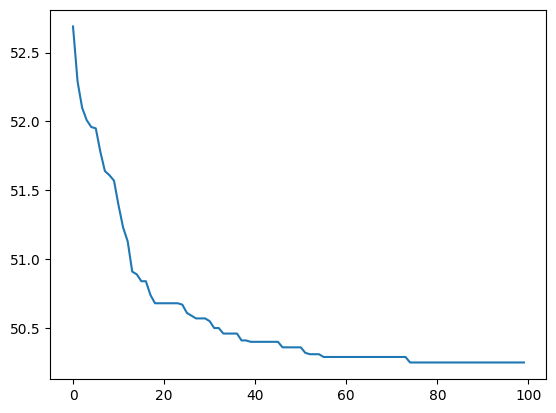

In [ ]:
import matplotlib.pyplot as plt
plt.plot(means)
plt.show()

In [ ]:
np.array(fit_results[0]).min()

46

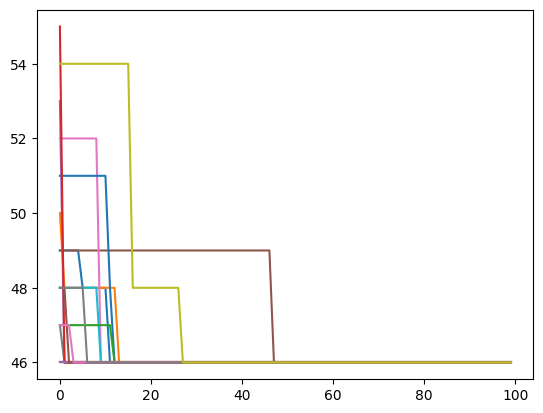

In [ ]:
import matplotlib.pyplot as plt
prom = []
for i in np_history_all_dim[0]:
  if i[-1] == np.array(fit_results[0]).min():

    plt.plot(i)
plt.show()

In [ ]:
np_fit_results = np.array(fit_results)
np_fit_results = np_fit_results.T
df = pd.DataFrame(np_fit_results, columns=[4,5,6,7])
df

,4,5,6,7
0,32,33,33,49
1,32,33,35,46
2,32,35,33,51
3,32,33,33,49
4,32,33,33,50
...,...,...,...,...
95,32,33,35,48
96,32,33,41,53
97,32,33,33,47
98,32,33,35,48
